# Init Tdx 

In [1]:
# import logging
import sys

# stdout=sys.stdout
sys.path.append('../../')
import os
import random
import time

import matplotlib
import matplotlib.pyplot as plt
import mplfinance as mpf
# sys.stdout=stdout
import numpy as np
# import numpy as np
import pandas as pd
from JohnsonUtil import commonTips as cct
from JSONData import sina_data
from JSONData import tdx_data_Day as tdd
from mplfinance.original_flavor import candlestick_ohlc

# from JSONData import tdx_hdf5_api as h5a

%matplotlib widget
plt.rc('font', family='SimHei', size=13)
matplotlib.get_backend()
# jupyter nbextension enable --py widgetsnbextension

os.environ['NUMEXPR_MAX_THREADS'] = '12'
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
import nest_asyncio

nest_asyncio.apply()

In [2]:
block_path = tdd.get_tdx_dir_blocknew() + '060.blk'

## 功能定义DEF

### bullish 测算

In [169]:
import numpy as np


def calculate_slope(data):
    # Calculate the slope of the line that connects two points
    slope = round((data[1] - data[0]) / (1), 2)
    return slope


def detect_bull_bear(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    for i in range(len(price_data) - window, len(price_data) - 1):
        slope = calculate_slope([price_data[i], price_data[i + 1]])
        # print(slope)
        slopes.append(slope)

    # Compare the current slope with the average slope of the last `window` days
    avg_slope = round(np.mean(slopes), 2)
    curr_slope = calculate_slope([price_data[-window], price_data[-1]])
    print(len(slopes), avg_slope, curr_slope)

    if curr_slope > avg_slope:
        # return "Bullish"
        return "Bull"
    else:
        return "Bear"


def detect_bull_bear_apply(price_data, window=10):
    # Calculate the slopes of the price data for the last `window` days
    slopes = []
    # try:
    if len(price_data) > 20:
        for i in range(len(price_data) - window, len(price_data) - 1):
            slope = calculate_slope([price_data[i], price_data[i + 1]])
            # print(slope)
            slopes.append(slope)

        # Compare the current slope with the average slope of the last `window` days
        avg_slope = round(np.mean(slopes), 2)
        curr_slope = calculate_slope([price_data[-window], price_data[-1]])
        # print(len(slopes), avg_slope, curr_slope)

        # if curr_slope > avg_slope:
        #     # return "Bullish"
        #     return "Bull"
        # else:
        #     return "Bear"
        return curr_slope
    else:
        return round((price_data[-1] - price_data[0]) / (1), 2)


code = '601360'
# Example usage
# price_data = [100, 95, 97, 99, 102, 105, 108, 111,1]
dfc = tdd.get_tdx_Exp_day_to_df(
    code, dl=60, resample='d').sort_index(
    ascending=True).reset_index()
# dfc = get_sina_data_cname(dfc)
price_data = dfc.close.values.tolist()
price_data[1], dfc.date[0]
price_data[-1], dfc.date[-1:]
print(detect_bull_bear(price_data))
print(detect_bull_bear_apply(price_data))

# Output: "Bullish"

(7.06, '2022-11-10')

(9.7,
 59    2023-02-09
 Name: date, dtype: object)

9 0.3 2.66
Bull
2.66


### regression_line(X, Y):

6.8 0.01
Above
0.25


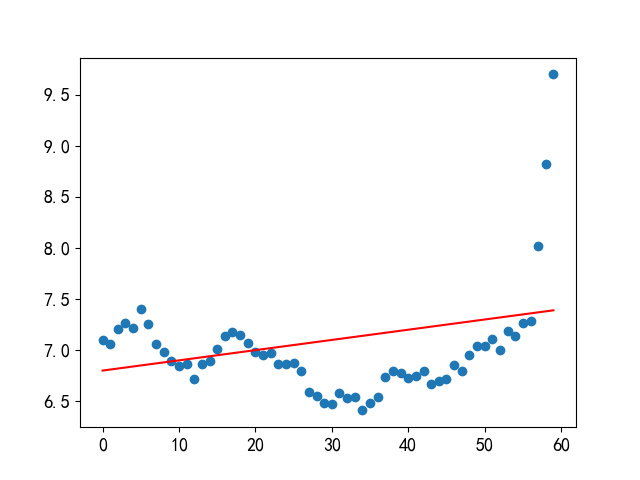

In [186]:


def regression_line(X, Y, limit=10,showall=False):
    # Calculate the coefficients of the regression line
    if not showall:
        X = X[-limit:]
        Y = Y[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x), 2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return a, b


def regression_ratio(df, limit=10):
    # Calculate the coefficients of the regression line
    df = df.reset_index()
    if isinstance(df, pd.Series):
        Y = df.values[-limit:]
        X = df.reset_index().index[-limit:]
    else:
        X = df.index[-limit:]
        Y = df.close[-limit:]
    n = len(X)
    sum_x = np.sum(X)
    sum_y = np.sum(Y)
    sum_xy = np.sum(X * Y)
    sum_xx = np.sum(X * X)
    # a = round((sum_y * sum_xx - sum_x * sum_xy) / (n * sum_xx - sum_x * sum_x),2)
    b = round((n * sum_xy - sum_x * sum_y) / (n * sum_xx - sum_x * sum_x), 2)
    return b


def predict_price(time, a, b):
    # Predict the price using the regression line
    price = a + b * time
    return price


def plot_regression_line(X, Y, a, b):
    # Plot the regression line
    plt.close()
    plt.scatter(X, Y)
    plt.plot(X, a + b * X, color="red")
    plt.show()


def detect_position(price, a, b, X):
    # Detect the position of the current price on the regression line
    regression_price = predict_price(X[-1], a, b)
    if price > regression_price:
        return "Above"
    elif price < regression_price:
        return "Below"
    else:
        return "On"


# Example usage
time_index = dfc.index
price = dfc.close.values
a, b = regression_line(time_index, price,showall=True)
print(a, b)
# Output: (100.0, 5.0)
print(detect_position(132, a, b, time_index))
print(regression_ratio(dfc))
plot_regression_line(time_index, price, a, b)

# print(detect_position(132, a, b, time))
# Output: "On"

In [168]:
dfc.columns

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'top10', 'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv',
       'lv'],
      dtype='object', length=112)

### check_postion_vol_price

In [6]:
from sklearn.linear_model import LinearRegression


def check_postion_vol_price(df):
    # 加载数据
    # df = pd.read_csv("data.csv")

    # 创建输入数据
    X = df[["close", "vol"]].values
    y = df["close"].values

    # 训练回归模型
    reg = LinearRegression().fit(X, y)

    # 计算斜率和截距
    slope = reg.coef_[0]
    intercept = reg.intercept_

    # 计算上轨和下轨
    upper_band = slope * df["close"] + intercept + 2 * df["vol"]
    lower_band = slope * df["close"] + intercept - 2 * df["vol"]

    # 判断价格是否在通道内
    df["Positon"] = np.where(
        df["close"] > upper_band, "Long", np.where(
            df["close"] < lower_band, "Short", "Neutral"))
    return df


dfc = check_postion_vol_price(dfc)
dfc[-1:]

,date,code,open,high,low,close,vol,amount,ma5d,ma10d,...,ma5dcum,ra,hmax,max5,lmin,min5,cmean,hv,lv,Positon
59,2023-02-09,301205,59.19,72.79,59.19,72.79,9710700.0,640809093.0,55.01,48.34,...,44.3,0,72.79,46.93,42.25,43.3,44.11,10849000.0,363100.0,Neutral


In [7]:

# dfc=  dfc.rename(columns={'date': 'Date', "open":"Open","high":"High","low": "Low","close":"Close"})
dfc.columns
# dfc[["Date", "Open", "High", "Low", "Close"]][-2:]
dfc.date[:3]
dfc.date = pd.to_datetime(dfc.date)
# dfc.set_index('date')
dfc.date[-1:]

Index(['date', 'code', 'open', 'high', 'low', 'close', 'vol', 'amount', 'ma5d',
       'ma10d',
       ...
       'ma5dcum', 'ra', 'hmax', 'max5', 'lmin', 'min5', 'cmean', 'hv', 'lv',
       'Positon'],
      dtype='object', length=113)

0    2022-11-10
1    2022-11-11
2    2022-11-14
Name: date, dtype: object

59   2023-02-09
Name: date, dtype: datetime64[ns]

### show_ohlc_upper 

xratio:0.25


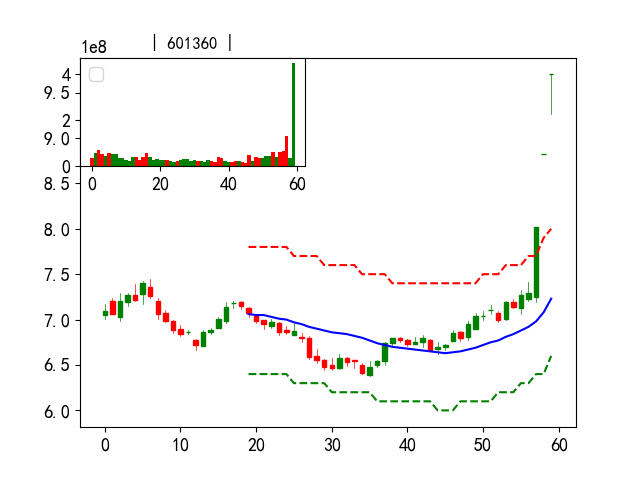

In [185]:

def show_ohlc_upper(df, code=None, allshow=True):
    # 加载数据
    # df = pd.read_csv("data.csv")
    plt.close()
    # 计算OHLC数据
    # df = df.rename(columns={'date': 'Date', "open": "Open",
    #                "high": "High", "low": "Low", "close": "Close"})
    # df.Date = df.Date.apply(lambda x:str(x).replace('-',''))
    if allshow:
        print("xratio:%s" % (regression_ratio(df)))
    # df=df[df.upper > 0]
    df = df.rename(columns={'vol': 'volume'})
    df = df.reset_index()
    # df.date = pd.to_datetime(df.index)
    df.date = df.index
    # print(df.Date)
    # ohlc = df[["Date", "Open", "High", "Low", "Close"]].values
    ohlc = df[["date", "open", "high", "low", "close", 'volume']].values

    # 计算上轨和下轨
    upper_band = df[df.upper != 0].upper
    lower_band = df[df.lower != 0].lower
    # print(lower_band)
    if 'ma20d' in df.columns:
        ma20d = df[df.ma20d > 0].ma20d
    elif 'ma20' in df.columns:
        ma20d = df[df.ma20 > 0].ma20
    else:
        print('not ma20 ma20d')
    idx = len(df) - len(upper_band)
    idx2 = len(df) - len(lower_band)
    if idx != idx2:
        print(idx, len(df), len(upper_band))
        print(idx2, len(lower_band))

    # 计算当前价格的位置
    position = ['' for i in range(len(df))]
    # print(idx,len(df) ,len(upper_band),position)
    for i in range(idx, len(upper_band), 1):
        # print(df["close"][i])
        # print(upper_band[i],df["low"][i])
        # print(lower_band[i])
        if df["close"][i] > upper_band[i]:
            position[i] = 'Upp'
        elif df["low"][i] < lower_band[i]:
            position[i] = 'Low'
        # else:
            # position[i] = 'Middle Band'
    # print(position)
    # 绘制OHLC图
    fig, ax = plt.subplots()
    candlestick_ohlc(ax, ohlc, width=0.6, colorup='g', colordown='r')

    # 添加上轨和下轨
    plt.plot(upper_band.index, upper_band, 'r--', label='Upper Band')
    plt.plot(lower_band.index, lower_band, 'g--', label='Lower Band')
    plt.plot(ma20d.index, ma20d, 'b', label='ma20')

    if 'hat' in df.columns:
        plt.plot(df.hat.index, df.hat, 'b', label='hat')
    # 添加位置
    for i, txt in enumerate(position):
        if txt == 'Low':
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, -30), textcoords='offset points', color='g')
        else:
            plt.annotate(txt, (df["date"][i], df["close"][i]), xytext=(
                0, 20), textcoords='offset points', color='g')
    axx = fig.add_subplot(321)
    # axx.plot(df[["volume"]])
    # from matplotlib import transforms
    # pad = 0.25
    # yl = ax.get_ylim()
    # ax.set_ylim(yl[0]-(yl[1]-yl[0])*pad,yl[1])
    # axx = ax.twinx()
    # axx.set_position(transforms.Bbox([[0.125,0.1],[0.9,0.32]]))

    volume = np.asarray(df.volume)
    pos = df['open'] - df['close'] < 0
    neg = df['open'] - df['close'] >= 0
    idx = np.asarray([x for x in range(len(df.date))])
    # print len(dates),len(df),ax.get_xlim(),ax.get_xticks()
    axx.bar(idx[pos], volume[pos], color='red', width=1, align='center')
    axx.bar(idx[neg], volume[neg], color='green', width=1, align='center')

    # position = ['' for i in range(len(df))]
    # position = df.Positon
    # for i, txt in enumerate(position):
    #     plt.annotate(txt, (df["Date"][i], df["Close"][i]), xytext=(0,20), textcoords='offset points')
    # 添加图例
    plt.legend(loc='best')
    # plt.legend(["Now:%s" % df.close[-1], "Hi:%s" % df.high[-1], "Lo:%0.2f" % (asset.iat[-1]), "day:%s" %
    #             len(asset), "fib:%s" % (fib),"MA:%s"%(roll_mean_days)], fontsize=12, loc=0)
    if 'name' in df.columns:
        if 'code' in df.columns:
            plt.title(df.name.values[-1:]
                      [0] + " " + df.code[0] + " | ", fontsize=12)
        else:
            plt.title(df.name.values[-1:][0] + " " + " | ", fontsize=12)

    else:
        if 'code' in df.columns:
            plt.title(" | " + df.code[0] + " | ", fontsize=12)
        else:
            if code is None:
                plt.title(" | " + " | ", fontsize=12)
            else:
                plt.title(" | " + code + " | ", fontsize=12)

    # 显示图形
    plt.show()


show_ohlc_upper(dfc)

In [112]:
'code' in dfc.columns

True

### show_channel_mpl

In [9]:
dfc['position'] = 0


def show_channel_mpl_bug(df, limit=60):
    # Compute the channel
    def compute_channel(df):
        # Compute the high and low of the past n periods
        n = 20
        high = df['high'].rolling(window=n, min_periods=n).max()
        low = df['low'].rolling(window=n, min_periods=n).min()
        df['upper_channel'] = high + (high - low) * 0.5
        df['lower_channel'] = low - (high - low) * 0.5

        # Update the position based on the current price
        df['position'] = np.where(df['close'] > df['upper_channel'] * 0.66, 1,
                                  np.where(df['close'] < df['lower_channel'], -1, 0))
        # print(df['position'])

    df = df.rename(columns={'vol': 'volume'})
    # df = df.reset_index()
    if 'date' in df.columns:
        df.date = pd.to_datetime(df.date)
    else:
        df = df.reset_index()
        df.date = pd.to_datetime(df.date)
    df = df.set_index('date')
    # df.date = df.index
    df = df.loc[:, ["open", "high", "low", "close", 'volume']]
    compute_channel(df)

    # fig, ax = plt.subplots()
    # Plot the ohlc chart
    mpf.plot(df, type='candle', title='OHLC chart with channel and position',
             ylabel='Price', volume=True, mav=(10, 20),
             show_nontrading=False, ylabel_lower='Position')
    # returnfig=True)

    # for i, txt in enumerate(df.position):
    #     # print(i,txt,df.index[i], df["close"][i])
    #     if txt == 0:
    #         plt.annotate("Down", (df.index[i], df["close"][i]), xytext=(
    #             0, -30), textcoords='offset points', color='g')
    #     else:
    #         plt.annotate("UP", (df.index[i], df["close"][i]), xytext=(
    #             0, 20), textcoords='offset points', color='g')

    # axlist[0].set_yticks([-1, 0, 1])
    # axlist[2].xaxis.set_ticks(df['position'])
    # axlist[2].set_xticklabels(df['upper_channel'])
    # yticks=[-1, 0, 1], yticklabels=['Sell', 'Hold', 'Buy'],
    # overlays=[(df['upper_channel'], None), (df['lower_channel'], None)])
# show_channel_mpl(dfc)

## TDX def

In [45]:
global sina_dm
sina_dm = None


def get_sina_data_cname(df, dm=None, index=False, realtime=False):
    # index_status=False
    global sina_dm
    if dm is None:
        if sina_dm is None:
            dm = sina_data.Sina().market('all')
        else:
            dm = sina_dm.copy()

    if 'ticktime' in df.columns:
        time_l = time.mktime(dm.loc[:, 'ticktime'][-1].timetuple())
        dur = round((time.time() - time_l) / 60, 2)
        if dur > 5:
            print("timel > 5,renew dm")
            dm = sina_data.Sina().market('all')
            sina_dm = dm.copy()

    if realtime:
        print("compute percent")
        df.rename(columns={'low': 'llow',
                  'high': 'lhigh', 'open': 'lopen'}, inplace=True)
        if 'nclose' in dm.columns:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:,
                 ['nclose', 'close', 'name', 'open', 'high', 'low', 'llastp',
                  'ticktime']],
                clean=True)
        else:
            dd = cct.combine_dataFrame(
                df, dm.loc
                [:, ['close', 'name', 'open', 'high', 'low', 'llastp', 'ticktime']],
                clean=True)
        dd['perc'] = ((dd['close'] - dd['llastp']) / dd['llastp'] *
                      100).map(lambda x: round(x, 2))
        # dd = cct.combine_dataFrame(df, dm['name'])

    else:
        dd = cct.combine_dataFrame(df, dm['name'])
    # cname = sina_data.Sina().get_code_cname(code)
    return dd


def write_code_to_blk(codew, blk='060'):
    block_path = tdd.get_tdx_dir_blocknew() + '%s.blk' % (blk)
    write_blk = 'n'
    write_blk = cct.cct_raw_input("write blk [Y] or [N]:")
    if write_blk == 'y' or write_blk == 'Y':
        hdf5_wri = cct.cct_raw_input(
            "Rewrite code [Y] or append [N](defalut:N):")
        if hdf5_wri == 'y' or hdf5_wri == 'Y':
            append_status = False
        else:
            append_status = True
        if len(codew) > 3:
            cct.write_to_blocknew(block_path, codew, append_status,
                                  doubleFile=False, keep_last=0)
            ("write:%s block_path:%s" % (len(codew), block_path))
        else:
            ("write error:%s block_path:%s" % (len(codew), block_path))
    return True


def clean_688(df):
    df = df[(~df.index.str.contains("688"))]
    return df


def compute_perd_value(df, market_value=3, col="vol", col_new='volsum'):

    # if market_value == None or market_value < "2":
    #     market_value = 3
    # if market_value > 1 and len(df[ df["%s%sd" % (col, market_value)] > 2])   :
    market_value = str(market_value)
    if market_value > str(1):
        temp = df[
            df.columns[
                (df.columns >= "%s1d" % (col)) &
                (df.columns <= "%s%sd" % (col, market_value))
            ]
        ]

        df['%s%sd' % (col_new, market_value)] = temp.T.sum().apply(
            lambda x: round(x, 1))
    else:
        print("market_value <= 1,No Compute")

    return df


def show_tdx_data(df, codelist=None, market_value='3', col=None):
    col_src = [
        "name", "couts", "date", "perc", "xratio", "idx", "hat", "close",
        "volsum5d", "hmax", "lmin", "perc1d", "ma20", "ma250", "nclose",
        "llow", 'vol1d', 'vol2d', 'vol3d', 'vol4d', 'vol5d', "perc%sd" %
        (market_value),
        "perc5d"]

    if isinstance(df, pd.Series):
        col_name = [co for co in col_src if co in df.index]
        # col_name.insert(1,'date')
    else:
        col_name = [co for co in col_src if co in df.columns]

    # print(col_name)
    # if isinstance(df, pd.DataFrame) and 'name' in df.columns:
    #     columns_ = col_name
    # else:
    #     if isinstance(df, pd.Series) and 'name' in df.index:
    #         columns_ = col_name.insert(1, "date")
    #     else:
    #         columns_ = col_name.remove("name")
    if col is not None:
        col_name.insert(4, col)

    if codelist is None:
        if isinstance(df, pd.Series):
            print("Count:1")
            temp = df.loc[col_name]
        else:
            print("Count:%s %s" % (df.shape))
            temp = df.loc[:, col_name]
    else:
        temp = df.loc[[x for x in codelist if x in df.index], col_name]
    return temp


def get_multi_date_duration(df, dt):
    dd = df.reset_index()
    dd = dd[dd.date >= dt]
    # dd['couts'] = dd.groupby(['code'])['code'].transform('count')
    dd = dd.set_index(['code', 'date'])
    return dd


def get_multi_code_count(df, col='code'):
    dd = df.reset_index()
    dd['couts'] = dd.groupby([col])[col].transform('count')
    dd = dd.sort_values(by=['couts', 'date'], ascending=[0, 1])
    print('count dd.couts')
    dd = dd.set_index(['code', 'date'])
    return dd


def multindex_iloc(df, index):
    label = df.index.levels[0][index]
    return df.iloc[df.index.get_loc(label)]


def get_groupby_mean_median_close(dfs):

    groupd = dfs.groupby(level=[0])

    df = groupd['close'].agg(['median', 'mean'])
    df['close'] = groupd.tail(1).reset_index().set_index(['code'])['close']
    # dfs['mean'] = groupd['close'].agg('mean')
    # dfs['median'] = groupd['close'].agg('median')

    # dfs = dfs.fillna(0)
    # idx = pd.IndexSlice
    # mask = ( (dfs['mean'] > dfs['median'])
    #         & (dfs['close'] > dfs['mean'])
    #         )
    # df=dfs.loc[idx[mask, :]]

    df = df[(df['mean'] > df['median']) & (df['close'] > df['mean'])]

    # dt_low = None
    # if dl == 1:
    #     dfs = groupd.tail(1)
    #     print("dfs tail1")
    # else:
    #     dl = 30
    #     dindex = tdd.get_tdx_Exp_day_to_df(
    #         '999999', dl=dl).sort_index(ascending=False)
    #     dt = tdd.get_duration_price_date('999999', df=dindex)
    #     dt = dindex[dindex.index >= dt].index.values
    #     dt_low = dt[-1]
    #     dtlen = len(dt) if len(dt) >0 else 1
    #     dfs = groupd.tail(dtlen)
    #     print("dfs tail:%s dt:%s"%(dtlen,dt))
    #     dfs = get_multi_date_duration(dfs,dt[-1])
    return df


def compute_df_Col_lastday(dfs, col='close', colre='perc', days=3, plus=True):
    for da in range(int(days)):
        da += 1
        if plus:
            dfs['%s%sd' % (colre, da)] = round(
                (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
        else:
            if da == 1:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col] - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
            else:
                dfs['%s%sd' % (colre, da)] = round(
                    (dfs[col].shift(da - 1) - dfs[col].shift(da)) / dfs[col].shift(da) * 100, 2)
    return dfs

In [11]:
def get_roll_mean_all(
        single=True, tdx=False, app=True, duration=100, ma_250_l=1.02,
        ma_250_h=1.11, resample='d'):
    time_s = time.time()
    if not app and cct.get_file_size(block_path) > 100 and cct.creation_date_duration(block_path) == 0:
        print("It's Today Update")
        return True
    code_list = sina_data.Sina().market('all').index.tolist()
    code_list.extend(['999999', '399001', '399006'])
    print("all code:", len(code_list))
    if duration < 300:
        h5_fname = 'tdx_all_df' + '_' + str(300)
        h5_table = 'all' + '_' + str(300)
    else:
        h5_fname = 'tdx_all_df' + '_' + str(900)
        h5_table = 'all' + '_' + str(900)
    # df = tdd.search_Tdx_multi_data_duration('tdx_all_df_300', 'all_300', df=None,code_l=code_list, start='20150501', end=None, freq=None, col=None, index='date')
    df = tdd.search_Tdx_multi_data_duration(
        h5_fname, h5_table, df=None, code_l=code_list, start=None, end=None,
        freq=None, col=None, index='date')
    # df = tdd.search_Tdx_multi_data_duration(h5_fname, h5_table, df=None,code_l=code_list, start=None, end=None, freq=None, col=None, index='date',tail=1)

    code_uniquelist = df.index.get_level_values('code').unique()

    code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]
    print(round(time.time() - time_s, 2), df.index.get_level_values(
        'code').unique().shape, code_select, df.loc[code_select].shape)
    # df.groupby(level=[0]),df.index.get_level_values(0)
    # len(df.index.get_level_values('code').unique())
    # df = df[~df.index.duplicated(keep='first')]

    # multiIndex_func = {'close': 'mean', 'low': 'min', 'high': 'max', 'volume': 'sum', 'open': 'first'}
    # cct.using_Grouper(df, freq='W', col={'close': 'last'})
    # *** TypeError: Only valid with DatetimeIndex, TimedeltaIndex or PeriodIndex, but got an instance of 'Index'
    # roll_dl = duration

    if resample != 'd':
        print("resample:%s" % (resample.upper()))
        # ohlc_dict = {'volume': 'sum','high': 'max','low': 'min','close': 'last'}
        # {'low': 'min', 'close':'mean'}
        # df = df.groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1).agg({'close':'last'})
        df = df.loc[:, ['close']].groupby(level=0).resample(
            resample, level=1).agg({'close': 'last'}).dropna()

        df = df.dropna()
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(level=0).resample(resample, level=1, how={'low': 'min', 'close':'mean'})
        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.Grouper(freq=resample)).transform(np.cumsum).resample(resample, how='ohlc')

        # df = df.loc[:, ['open','close', 'low', 'high']].groupby(pd.TimeGrouper(resample)).transform(np.cumsum).resample(resample, how='ohlc')
        # r1 = len(df.loc['000001'])
        # r2 = len(df.loc['999999'])
        # roll_dl = r1 if r1 < r2 else r2

        # df['upper'] = map(lambda x: round((1 + 11.0 / 100) * x, 1), df.ma10d)
        # df['lower'] = map(lambda x: round((1 - 9.0 / 100) * x, 1), df.ma10d)
        # df['ene'] = map(lambda x, y: round((x + y) / 2, 1), df.upper, df.lower)
        # dfs['amount%d'%cumdays] = groupd['amount'].apply(pd.rolling_mean, cumdays)
    # df.ix[df.index.levels[0]]
    # df.ix[df.index[len(df.index)-1][0]] #last row
    # dfs = tdd.search_Tdx_multi_data_duration(df=dfs,code_l=code_list, start='20170918', end='20170918', freq=None, col=None, index='date')

    # print dfs[:1],len(dfs)
    # groupd.agg({'low': 'min'})
    # '''idx mask filter'''
    # '''
    # h5a.write_hdf_db('all300', df, table='roll200', index=False,baseCount=500, append=False, MultiIndex=MultiIndex)
    df = df.reset_index().sort_values(
        by=['code', 'date'],
        ascending=[0, 1]).set_index(
        ['code', 'date'])
    print("use time:%s" % (round(time.time() - time_s, 2)))
    return df

# 读取数据

In [12]:
resample = 'd'

df = get_roll_mean_all(
    single=False, tdx=True, app=True, duration=250, ma_250_l=1.02,
    ma_250_h=1.2, resample=resample)


# df= df.groupby(level=[0]).tail(1).reset_index().set_index('code')
# df_cname = tdd.get_sina_datadf_cnamedf(df.index.tolist(), df)
# df = df.reset_index().set_index(['code', 'date'])

all code: 5062
32.43 (4961,) 000521 (303, 6)
use time:33.1


## df_regression_ratio

In [74]:
df_reg_ratio = df.groupby(level=[0])['close'].apply(regression_ratio)
df_reg_ratio.shape, df_reg_ratio[:2]

((4961,),
 code
 000001   -0.14
 000002   -0.11
 Name: close, dtype: float64)

In [75]:
df_reg_ratio.shape, df_reg_ratio.loc['301205']

((4961,), 2.97)

## df_idx_detect

In [76]:
df_idx_detect = df.groupby(level=[0])['close'].apply(detect_bull_bear_apply)
df_idx_detect.shape, df_idx_detect[-5:]
df.loc['688072'][-1:]
# show_ohlc_upper()
# df[:10]

((4961,),
 code
 688800    17.03
 688819     0.27
 688981     1.01
 689009     1.98
 999999     5.57
 Name: close, dtype: float64)

,open,high,low,close,vol,amount,idx,xratio
date,,,,,,,,
2023-02-09,231.0,247.67,230.11,245.56,989558.0,239078303.0,-13.25,1.56


## Combine ratio and idx

In [77]:
df = df.reset_index().set_index('code')
df['idx'] = df_idx_detect
df['xratio'] = df_reg_ratio
df = df.reset_index().set_index(['code', 'date'])

In [144]:
df.loc['300114'][:10]

,open,high,low,close,vol,amount,idx,xratio
date,,,,,,,,
2021-10-27,15.35,15.60,14.00,14.17,19566100.0,289578280.0,20.96,2.32
2021-10-28,14.12,14.33,13.66,13.98,11821000.0,165434895.0,20.96,2.32
2021-10-29,13.97,14.36,13.88,14.24,8856000.0,125046720.0,20.96,2.32
2021-11-01,14.16,15.11,14.16,15.04,13000600.0,190263781.0,20.96,2.32
2021-11-02,15.22,15.74,15.22,15.60,17185400.0,266029992.0,20.96,2.32
2021-11-03,15.61,15.64,15.09,15.29,9356600.0,143764159.0,20.96,2.32
2021-11-04,15.25,15.79,15.18,15.64,11701300.0,181194630.5,20.96,2.32
2021-11-05,15.60,16.02,15.51,15.53,11180300.0,176257429.5,20.96,2.32
2021-11-08,15.53,15.60,14.65,14.98,16513000.0,249759125.0,20.96,2.32


## sina_dm

In [79]:
sina_dm = sina_data.Sina().market('all')
lastday = cct.last_tddate()
lastday

'2023-02-09'

In [81]:
cct.get_time_to_date(time.time(), format='%Y-%M-%D %H:%M:%S')

'2023-26-02/10/23 13:26:56'

In [82]:
# abc=dm.loc[:,'ticktime'][-1]
sina_dm.ticktime[-2:]

code
300304   2023-02-10 13:25:21
300601   2023-02-10 13:25:18
Name: ticktime, dtype: datetime64[ns]

In [83]:
# dm.ticktime[:1]
sina_dm.loc[:, 'ticktime'][-1]
# time.strptime(abc,format='%Y-%m-%d %H:%M:%S')
# (time.mktime(abc.timetuple()))
(time.time() - time.mktime(sina_dm.loc[:, 'ticktime'][-1].timetuple())) / 60

Timestamp('2023-02-10 13:25:18')

1.6575755715370177

## check HDF LastDate

In [84]:
df_tail1 = df.groupby(level=[0]).tail(1)
# df_tail1.index

df_tail1[df_tail1.index.get_level_values('date') == cct.get_today()].shape
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()].shape

(0, 8)

(4961, 8)

In [85]:
df_tail1[df_tail1.index.get_level_values('date') != cct.get_today()][:1]

,,open,high,low,close,vol,amount,idx,xratio
code,date,,,,,,,,
999999,2023-02-09,3227.7278,3270.3826,3225.7724,3270.3826,254754529.0,3.517608e+11,5.57,-2.48


In [86]:
df.info()
code_t = '600519'
print(df.loc[code_t][-3:])
# df.loc['000001'][-1:]
# dfbak = df.copy()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1442494 entries, ('999999', Timestamp('2021-11-10 00:00:00')) to ('000001', Timestamp('2023-02-09 00:00:00'))
Data columns (total 8 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1442494 non-null  float64
 1   high    1442494 non-null  float64
 2   low     1442494 non-null  float64
 3   close   1442494 non-null  float64
 4   vol     1442494 non-null  float64
 5   amount  1442494 non-null  float64
 6   idx     1442494 non-null  float64
 7   xratio  1442494 non-null  float64
dtypes: float64(8)
memory usage: 93.8+ MB
               open     high      low   close        vol        amount    idx  \
date                                                                            
2023-02-07  1808.08  1808.80  1787.73  1797.0  2432171.0  4.373672e+09 -42.01   
2023-02-08  1800.01  1805.97  1775.00  1784.0  1667577.0  2.980575e+09 -42.01   
2023-02-09  1778.00  1829.75  1775.01  1818.0  29753

## reindex sort date

In [87]:
# df = df.reset_index().sort_values(by=['code', 'date'], ascending=[0, 1]).set_index(['code','date'])

## 初始化参数

In [ ]:
app = True
tdx = True
duration = 300
ma_250_l = 1.02
ma_250_h = 1.2


time_s = time.time()
dfs = df.copy()
# dfs = df.loc['600519']
# groupd = dfs.groupby(level=[0])
# groupd.['close']
# rollma = ['5','10','60','100','200']
# rollma = ['5','10','250']
# df.index.get_level_values('code')[0]
if resample.upper() == 'D' or resample.lower() == 'd':
    if duration < 300:
        rollma = ['10', '5', '20', '200']
    else:
        rollma = ['10', '5', '20', '250']

elif resample.upper() == 'W' or resample.lower() == 'w':
    rollma = ['5', '10']
else:
    rollma = ['5', '10']

# rollma.extend([str(duration)])

# import ipdb;ipdb.set_trace()
# df.loc['300130'][:2]

# dfs['mean'] = groupd['close'].agg('mean')
# dfs['median'] = groupd['close'].agg('median')

# BOLL:MA(CV,N), COLORMAGENTA;
# UPPER:BOLL+P*STD(CV,N), COLORYELLOW;
# LOWER:BOLL-P*STD(CV,N), COLORYELLOW;
# df['BollUpper'] = df.close.shift(10).mean()+2*df.close.shift(10).std()
# df['BollDown'] = df.close.shift(10).mean()-2*df.close.shift(10).std()
for da in rollma:
    cumdays = int(da)
    dfs['ma%d' % cumdays] = round(dfs['close'].rolling(cumdays).mean(), 2)

    # dfs['upper'] = dfs['ma%d' % cumdays].apply(
    #     lambda x: round((1 + 11.0 / 100) * x, 1))
    # dfs['lower'] = dfs['ma%d' % cumdays].apply(
    #     lambda x: round((1 - 9.0 / 100) * x, 1))
    # dfs['boll'] = list(map(lambda x, y: round(
    #     (x + y) / 2, 1), dfs['upper'], dfs['lower']))
dfs['upper'] = round(
    dfs['close'].rolling(20).mean() + 2 *
    dfs['close'].rolling(20).std(),
    2)
dfs['lower'] = round(
    dfs['close'].rolling(20).mean() - 2 *
    dfs['close'].rolling(20).std(),
    2)
dfs['boll'] = round(dfs['close'].rolling(20).mean(), 2)

dfs['hmax'] = round(dfs['high'].rolling(20).max(), 2)
dfs['lmin'] = round(dfs['low'].rolling(20).min(), 2)

dfs['hat'] = dfs['upper'] - dfs['lower']

# dfs['hmax'] = round(dfs['close'].cummax(), 2)


dfs = compute_df_Col_lastday(dfs, col='close', colre='perc', days=5)
dfs = compute_df_Col_lastday(dfs, col='vol', colre='vol', days=5, plus=False)
dfs = compute_perd_value(dfs, market_value=5, col='vol', col_new='volsum')

# dfs['perc1d'] = round(
#     (dfs['close'] - dfs['close'].shift(1)) / dfs['close'].shift(1) * 100, 2)
# dfs['perc3d'] = round(
#     (dfs['close'] - dfs['close'].shift(3)) / dfs['close'].shift(3) * 100, 2)
# dfs['perc5d'] = round(
#     (dfs['close'] - dfs['close'].shift(5)) / dfs['close'].shift(3) * 100, 2)

In [ ]:
# dfs.loc['688027']
dfs['ma51d'] = round(dfs['close'].rolling(5).mean(), 2)
show_tdx_data(dfs.loc['600519'][-3:])
# show_tdx_data(dfs.loc['600519'])

Count:3 30


,xratio,idx,hat,close,volsum5d,hmax,lmin,perc1d,ma20,ma250,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
date,,,,,,,,,,,,,,,,,
2023-02-07,-9.2,-42.01,183.05,1797.0,-12.9,1935.0,1716.0,0.11,1843.52,1765.08,-42.99,22.08,17.43,-12.41,2.98,-2.13,-2.64
2023-02-08,-9.2,-42.01,156.57,1784.0,-47.3,1935.0,1733.0,-0.72,1846.47,1764.45,-31.44,-42.99,22.08,17.43,-12.41,-1.87,-3.30
2023-02-09,-9.2,-42.01,153.12,1818.0,43.5,1935.0,1760.0,1.91,1847.32,1764.10,78.42,-31.44,-42.99,22.08,17.43,1.28,-0.99


In [ ]:
dfs = dfs.dropna()
groupd = dfs.groupby(level=[0])
single = False
dt_low = None
df_idx = None
if single:
    dfs_dtlen = groupd.tail(1)
    print("dfs tail1")
else:
    single = True
    dl = 30
    dindex = tdd.get_tdx_Exp_day_to_df(
        '999999', dl=dl, resample=resample).sort_index(ascending=False)
    dt = tdd.get_duration_price_date('999999', df=dindex)

    dt = dindex[dindex.index >= dt].index.values
    dt_low = dt[-1]
    print('dt_low:%s' % (dt_low))
    dtlen = len(dt) if len(dt) > 0 else 1
    dfs_dtlen = groupd.tail(dtlen)
    # import ipdb;ipdb.set_trace()
    df_idx = get_groupby_mean_median_close(dfs_dtlen)

    print(("dfs tail:%s dt:%s" % (dtlen, dt)))
    dfs_dtlen = get_multi_date_duration(dfs_dtlen, dt[-1])

# groupd2 = dfs.groupby(level=[0])
# dfs['ma%d'%cumdays] = groupd['close'].apply(pd.rolling_mean, cumdays)

# dfs.reset_index().groupby(['code'])['date'].transform('count')
# single = True

print("Low:%s" % (dt[-1]))
dfs_dtlen[:5]
dfs_dtlen[('ma%s') % (rollma[-1])][:2]
print(df_idx)

dt_low:2022-12-23
dfs tail:29 dt:['2023-02-09' '2023-02-08' '2023-02-07' '2023-02-06' '2023-02-03'
 '2023-02-02' '2023-02-01' '2023-01-31' '2023-01-30' '2023-01-20'
 '2023-01-19' '2023-01-18' '2023-01-17' '2023-01-16' '2023-01-13'
 '2023-01-12' '2023-01-11' '2023-01-10' '2023-01-09' '2023-01-06'
 '2023-01-05' '2023-01-04' '2023-01-03' '2022-12-30' '2022-12-29'
 '2022-12-28' '2022-12-27' '2022-12-26' '2022-12-23']
Low:2022-12-23


open     high      low    close          vol  \
code   date                                                          
999999 2022-12-23  3038.84  3061.87  3031.54  3045.87  192020305.0   
       2022-12-26  3048.20  3071.84  3047.35  3065.56  206503893.0   
       2022-12-27  3077.75  3098.08  3074.31  3095.57  222218322.0   
       2022-12-28  3088.62  3098.65  3079.43  3087.40  224554151.0   
       2022-12-29  3076.73  3086.00  3064.46  3073.70  215570676.0   

                         amount   idx  xratio     ma10      ma5  ...  perc3d  \
code   date                                                      ...           
999999 2022-12-23  2.333352e+11  5.57   -2.48  3121.80  3069.92  ...   -0.91   
       2022-12-26  2.554703e+11  5.57   -2.48  3110.45  3061.61  ...   -0.09   
       2022-12-27  2.679468e+11  5.57   -2.48  3102.38  3065.97  ...    1.35   
       2022-12-28  2.605085e+11  5.57   -2.48  3093.46  3069.77  ...    1.36   
       2022-12-29  2.539170e+11  5.57   -2.48  3083.97  3073.62  ...    0.27   

                   perc4d  perc5d  vol1d  vol2d  vol3d  vol4d  vol5d  \
code   date                                                            
999999 2022-12-23   -1.97   -3.85 -14.14  18.29 -13.60 -21.43   7.21   
       2022-12-26   -0.27   -1.34   7.54 -14.14  18.29 -13.60 -21.43   
       2022-12-27    0.89    0.71   7.61   7.54 -14.14  18.29 -13.60   
       2022-12-28    1.08    0.62   1.05   7.61   7.54 -14.14  18.29   
       2022-12-29    0.91    0.63  -4.00   1.05   7.61   7.54 -14.14   

                   volsum5d    ma51d  
code   date                           
999999 2022-12-23     -23.7  3069.92  
       2022-12-26     -23.3  3061.61  
       2022-12-27       5.7  3065.97  
       2022-12-28      20.3  3069.77  
       2022-12-29      -1.9  3073.62  

[5 rows x 30 columns]

code    date      
999999  2022-12-23    3249.33
        2022-12-26    3247.00
Name: ma250, dtype: float64

        median        mean   close
code                              
000004    9.78    9.839655   10.22
000009   12.26   12.263448   12.71
000012    6.91    6.937931    7.16
000016    4.66    4.681379    4.84
000019    7.56    7.583448    7.77
...        ...         ...     ...
688787   64.82   83.669310  184.52
688788   39.28   39.531724   43.97
688789  172.63  176.606552  198.30
688798  108.18  109.408966  119.56
688981   41.87   42.008621   43.60

[2898 rows x 3 columns]


## 基础处理

In [32]:
time_s = time.time()


def get_mask_df(dfs):
    dfs = dfs.fillna(0)
    idx = pd.IndexSlice
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[1])])  & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])
    # mask = (dfs[('ma%s')%(rollma[0])] > dfs[('ma%s')%(rollma[1])]) & (dfs[('ma%s')%(rollma[-1])] > 0) &  (dfs[('close')] > dfs[('ma%s')%(rollma[-1])])

    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0) & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]) & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))
    # mask = ( (dfs[('ma%s')%(rollma[0])] > 0) & (dfs[('ma%s')%(rollma[-1])] > 0)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[-1])]*ma_250_l)
    #         & (dfs[('close')] < dfs[('ma%s')%(rollma[-1])]*ma_250_h)
    #         & (dfs[('close')] > dfs[('ma%s')%(rollma[0])]))

    # & (dfs['mean'] > dfs['median'])
    # & (dfs['close'] > dfs['mean'])

    if len(rollma) > 1:

        mask = ((dfs[('ma%s') % (rollma[0])] > 0) & (dfs[('ma%s') % (rollma[-1])] > 0) &
                (dfs[('ma%s') % (rollma[0])] > dfs[('ma%s') % (rollma[-1])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[0])]) &
                (dfs[('close')] > dfs[('ma%s') % (rollma[-1])]*ma_250_h) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']))
                )
    else:
        mask = ((dfs[('ma%s') % (rollma[0])] > 0) &
                (dfs[('close')] > dfs[('ma%s')%(rollma[0])]) &
                ((dfs[('close')] > dfs['boll']) | (dfs[('close')] > dfs['upper']) )
                )

    return dfs.loc[idx[mask, :]]

# mask = ((dfs[('close')] > dfs[('ma%s')%(rollma[-1])]))


df_mask = get_mask_df(dfs_dtlen)
print(df_mask.shape)
df_mask = get_multi_code_count(df_mask)
print((df_mask.couts[:5], df_mask.shape))

# import ipdb;ipdb.set_trace()
# df.sort_values(by='couts',ascending=0)
# groupd.first()[:2],groupd.last()[:2]
# groupd = df250.groupby(level=[0])
# '''
# groupd.transform(lambda x: x.iloc[-1])
# groupd.last()
# groupd.apply(lambda x: x.close > x.ma250)
# df.shape,df.sort_index(ascending=False)[:5]
# ?groupd.agg
# groupd = df.groupby(level=[0])
# groupd['close'].apply(pd.rolling_mean, 250, min_periods=1)
# ex:# Group df by df.platoon, then apply a rolling mean lambda function to df.casualties
# df.groupby('Platoon')['Casualties'].apply(lambda x:x.rolling(center=False,window=2).mean())

code_uniquelist = df_mask.index.get_level_values('code').unique()
code_select = code_uniquelist[random.randint(0, len(code_uniquelist) - 1)]

# if app:
#     print(round(time.time() - time_s, 2), 's', df.index.get_level_values(
#         'code').unique().shape, code_select, df.loc[code_select][-1:])

if single:
    # groupd = df.groupby(level=[0])
    if tdx:
        # block_path = tdd.get_tdx_dir_blocknew() + '060.blk'
        # if cct.get_work_time():
        #     codew = df[df.date == cct.get_today()].index.tolist()

        if dt_low is not None:

            groupd2 = df_mask.groupby(level=[0])
            df_mask = groupd2.tail(1)
            df_mask = df_mask.reset_index().set_index('code')
            # import ipdb;ipdb.set_trace()

            # df = df[(df.date >= dt_low) & (df.date <= cct.get_today())]
            dd = df_mask[(df_mask.date == dt_low)]
            # df = df[(df_mask.date >= cct.last_tddate(1))]
            df_mask = df_mask[(df_mask.date >= df_mask.date.max())]
            # import ipdb;ipdb.set_trace()
            print(("df:%s %s df_idx:%s" %
                  (len(df_mask), df_mask.index[:5], len(df_idx))))

            if df_idx is not None and len(df_mask) > 0 and len(df_idx) > 0:
                idx_set_ = [x for x in df_idx.index if x in df_mask.index]
                df_mask = df_mask.loc[idx_set_, :].dropna()
            print(("Main Down dd :%s MainUP df:%s couts std:%0.1f " %
                  (len(dd), len(df_mask), df_mask.couts.std())))
            # print df.date.mode()[0]
            df_mask = df_mask.sort_values(by='couts', ascending=1)
            df_mask = df_mask[df_mask.couts > df_mask.couts.std()]
            # df = df[(df.date >= df.date.mode()[0]) & (df.date <= cct.get_today())]
            codew = df_mask.index.tolist()

            if app:
                print(
                    "time: %s %s %s" %
                    (round(time.time() - time_s, 2),
                     'groupd2', len(df_mask)))

        else:
            df_mask = df_mask.reset_index().set_index('code')
            df_mask = df_mask[(df_mask.date >= cct.last_tddate(days=10)) &
                              (df_mask.date <= cct.get_today())]
            codew = df_mask.index.tolist()

        top_temp = tdd.get_sina_datadf_cnamedf(codew, df_mask)
        top_temp = top_temp[(~top_temp.index.str.contains(
            '688')) & (~top_temp.name.str.contains('ST'))]
        top_temp = top_temp.sort_values(by=['couts'], ascending=[0])
        codew = top_temp.index.tolist()

        # clean st and 688

    # df['date'] = df['date'].apply(lambda x:(x.replace('-','')))
    # df['date'] = df['date'].astype(int)
    # print df_mask.loc[code_select].T,df_mask.shape
#     MultiIndex = False
# else:
#     MultiIndex = True

(10584, 30)
count dd.couts
(code    date      
301239  2022-12-23    29
        2022-12-26    29
        2022-12-27    29
        2022-12-28    29
        2022-12-29    29
Name: couts, dtype: int64, (10584, 31))
df:626 Index(['301239', '603255', '301333', '301230', '600583'], dtype='object', name='code') df_idx:2898
Main Down dd :5 MainUP df:402 couts std:6.4 
time: 0.06 groupd2 240


In [33]:
dfs_dtlen.loc['002987'][:1]

,open,high,low,close,vol,amount,idx,xratio,ma10,ma5,...,perc3d,perc4d,perc5d,vol1d,vol2d,vol3d,vol4d,vol5d,volsum5d,ma51d
date,,,,,,,,,,,,,,,,,,,,,
2022-12-23,25.12,25.92,25.07,25.6,4349418.0,111461984.0,3.93,0.46,26.5,25.83,...,-1.2,-2.59,-3.03,-5.55,7.79,-24.84,10.06,-28.81,-41.4,25.83


# 最近30天筛选

In [145]:
# 截取最后5天数据
dfs_tail = dfs.groupby(level=[0]).tail(30)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
dfs_tail.loc['002987'][:1]

,open,high,low,close,vol,amount,idx,xratio,ma10,ma5,...,perc3d,perc4d,perc5d,vol1d,vol2d,vol3d,vol4d,vol5d,volsum5d,ma51d
date,,,,,,,,,,,,,,,,,,,,,
2022-12-22,25.76,26.18,25.3,25.41,4604867.0,118454952.0,3.93,0.46,26.73,25.99,...,-3.31,-3.75,-7.2,7.79,-24.84,10.06,-28.81,13.18,-22.6,25.99


In [146]:
mask250 = ((dfs_tail[('ma%s') % (rollma[0])] > 0) & (dfs_tail[('ma%s') % (rollma[-1])] > 0) &
           (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[0])])
            & (dfs_tail[('close')] > dfs_tail[('ma%s') % (rollma[-1])]*1.03)
              & (dfs_tail[('close')] < dfs_tail[('ma%s') % (rollma[-1])]*1.1)
                & (dfs_tail[('close')] > dfs_tail[('ma20')])
           & (dfs_tail[('close')] < dfs_tail[('ma20'   )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail.loc[idx[mask250, :]]
print(df_mask250.shape)
df_mask250 = get_multi_code_count(df_mask250)
print((df_mask250.couts[:1], df_mask250.shape))

groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1)

# df_mask250 = clean_688(df_mask250)

# df_mask250['idx'] = df_idx_detect
print((df_mask250.couts[:2], df_mask250.shape))
# print(df_mask.loc['002987'])
show_tdx_data(
    df_mask250.sort_values(
        by=['hat', 'couts', 'idx'],
        ascending=[0, 0, 0]))

(11192, 30)
count dd.couts
(code    date      
600674  2022-12-30    21
Name: couts, dtype: int64, (11192, 31))
(code    date      
300849  2023-02-07    21
600674  2023-02-09    21
Name: couts, dtype: int64, (1917, 31))
Count:1917 31


,,couts,xratio,idx,hat,close,volsum5d,hmax,lmin,perc1d,ma20,ma250,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
code,date,,,,,,,,,,,,,,,,,,
600519,2023-01-30,10,-9.20,-42.01,289.69,1888.00,17.5,1935.00,1701.05,1.50,1814.78,1765.81,40.27,9.26,11.28,-1.11,-42.20,-0.26,-1.30
688301,2023-01-18,13,-3.18,-19.70,99.20,475.88,-37.7,484.00,393.82,0.34,453.13,434.74,-4.63,-23.39,9.99,5.49,-25.19,2.34,3.14
300896,2023-01-03,4,-2.64,-15.90,77.38,555.63,225.3,576.88,501.41,-1.89,537.15,506.01,198.54,1.89,-8.18,-38.57,71.61,-1.83,3.09
688390,2022-12-29,3,-0.33,21.98,68.10,312.07,131.6,347.95,256.00,-0.93,301.12,287.12,-31.19,20.70,-40.54,31.50,151.14,4.73,11.92
300751,2023-01-31,13,-2.96,-22.36,56.33,443.71,61.2,455.88,397.77,-0.27,430.24,416.64,-24.05,66.21,-47.80,7.41,59.48,-0.56,0.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
601818,2023-01-30,7,-0.01,-0.09,0.11,3.08,48.8,3.13,2.98,-0.65,3.07,2.98,27.86,20.31,-54.90,95.35,-39.79,-0.32,0.33
601988,2023-01-31,19,-0.00,-0.01,0.11,3.22,40.8,3.25,3.12,-0.31,3.20,3.03,-40.90,99.48,23.42,-21.88,-19.32,0.00,0.00
601328,2023-02-09,19,-0.00,0.01,0.10,4.88,-37.5,4.92,4.78,0.21,4.85,4.63,2.68,-2.05,-22.23,-1.07,-14.85,0.83,0.62


xratio:-0.11


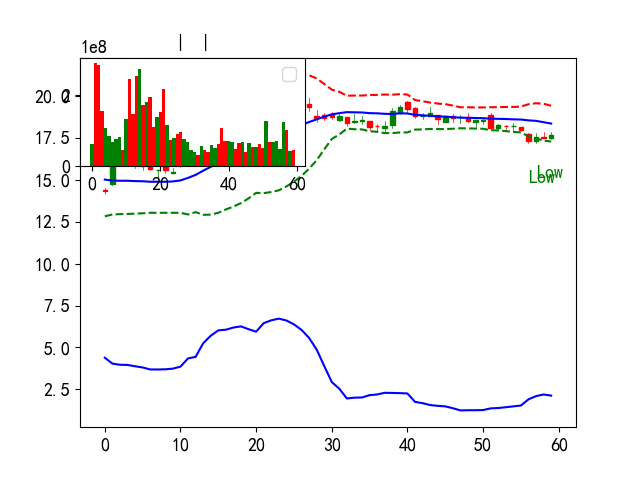

In [147]:
show_ohlc_upper(dfs.loc['000002'][-60:])

# 最近9天数据

In [148]:
dfs_tail9 = dfs.groupby(level=[0]).tail(9)

# 提取倒数第二天
# dfs_tail9 = dfs.groupby(level=[0]).tail(6)
# dfs_tail9 = dfs_tail9[dfs_tail9.index.get_level_values(1) <lastday]


# dfs_tail9.index.get_level_values(0)
# 还原多索引
# dfs_tail = dfs_tail.reset_index().set_index(['code','date'])
# print(dfs_tail9.loc['002987'][:1])
# show_tdx_data(dfs_tail9.loc[code_t])
# dfs_tail9=compute_perd_value(dfs_tail9,market_value=5,col='vol')

# show_tdx_data(dfs_tail9.loc[code_t])
# print((dfs_tail9.loc[code_t]))

## 超跌反弹年线大于MA20

In [183]:
show_tdx_data(dfs_tail9.loc['300418'])
# print(dfs_tail9.loc['300418'])

Count:9 30


,xratio,idx,hat,close,volsum5d,hmax,lmin,perc1d,ma20,ma250,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
date,,,,,,,,,,,,,,,,,
2023-01-30,0.79,6.76,1.44,15.46,366.5,16.25,13.72,4.11,14.52,15.16,354.28,5.20,-17.06,25.32,-1.21,4.96,5.96
2023-01-31,0.79,6.76,2.16,16.42,389.7,16.67,13.72,6.21,14.64,15.14,21.93,354.28,5.20,-17.06,25.32,10.35,12.62
2023-02-01,0.79,6.76,2.85,16.86,338.3,16.97,13.72,2.68,14.78,15.11,-26.06,21.93,354.28,5.20,-17.06,13.54,14.46
2023-02-02,0.79,6.76,4.11,18.23,502.6,19.17,13.83,8.13,14.99,15.09,147.21,-26.06,21.93,354.28,5.20,17.92,22.51
2023-02-03,0.79,6.76,5.04,18.50,450.2,19.17,13.83,1.48,15.22,15.08,-47.16,147.21,-26.06,21.93,354.28,12.67,24.58
2023-02-06,0.79,6.76,6.32,19.61,169.1,19.85,14.18,6.00,15.48,15.07,73.13,-47.16,147.21,-26.06,21.93,16.31,26.84
2023-02-07,0.79,6.76,7.94,20.98,170.4,22.15,14.25,6.99,15.80,15.06,23.33,73.13,-47.16,147.21,-26.06,15.09,27.77
2023-02-08,0.79,6.76,9.06,20.86,171.6,22.15,14.25,-0.57,16.11,15.06,-24.96,23.33,73.13,-47.16,147.21,12.76,23.72
2023-02-09,0.79,6.76,10.18,21.61,53.1,22.15,14.25,3.60,16.46,15.06,28.76,-24.96,23.33,73.13,-47.16,10.20,18.54


## Run-Filter强势Upper

### filterRule test

9 0.75 6.76


'Bull'

6.76

xratio:1.94


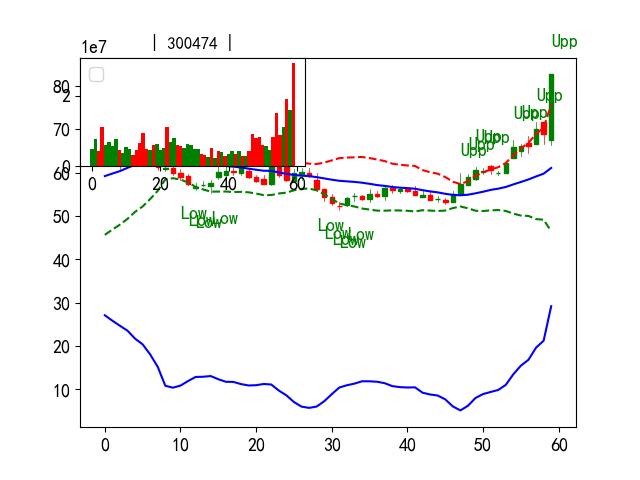

In [187]:
code_filter = '300418'
# dfs_tail9.loc['002722']


def rules_to_list(rules):
    rules_l = (rules).split('&')
    for l in rules_l:
        print(l)
    return rules_l


def filter_rule_Test(dfs_tail9):
    col_rule = ["(dfs_tail9[('close')] > dfs_tail9[('ma5')])",
                "(dfs_tail9[('high')] > dfs_tail9.upper)",
                "(dfs_tail9[('ma5')] > dfs_tail9[('ma20')])"]
    col_rule2 = [
        "(dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(1)*0.98) | (dfs_tail9['close'] > dfs_tail9['hmax']*0.97)",
        "((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))"]
    col_rule3 = [
        "((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))"]

    col_rule_tail1 = ["(dfs_tail9.perc1d < 21)", "(dfs_tail9.perc2d > 0)"]
    col_rule_tail2 = [
        "((dfs_tail9.perc3d > 0) | ((dfs_tail9.close.shift(2) > dfs_tail9.ma5.shift(2))) )",
        "((dfs_tail9.volsum5d > 50) )",
        "(dfs_tail9['close'] > dfs_tail9[('hmax')])",
        "(dfs_tail9[('close')] > dfs_tail9[('ma250')])",
        "(dfs_tail9['low'] > dfs_tail9[('low')].shift(1))"]
    col_rule.extend(col_rule2)
    col_rule.extend(col_rule3)
    col_rule.extend(col_rule_tail1)
    col_rule.extend(col_rule_tail2)

    for co in col_rule:
        print("%s:%s" % (co, eval(co)), end='')


# filter_rule_Test(dfs_tail9.loc[code_filter])
# show_tdx_data(dfs_tail9.loc[code_filter])
detect_bull_bear(dfs.loc[code_filter][-120:].close)
detect_bull_bear_apply(dfs.loc[code_filter][-120:].close)
show_ohlc_upper(dfs.loc['300474'][-60:], code='300474')
# dfs.loc[code_filter]

In [188]:
dfs.loc['300474'][-5:]

,open,high,low,close,vol,amount,idx,xratio,ma10,ma5,...,perc3d,perc4d,perc5d,vol1d,vol2d,vol3d,vol4d,vol5d,volsum5d,ma51d
date,,,,,,,,,,,,,,,,,,,,,
2023-02-03,64.98,66.66,63.80,66.25,8928770.0,5.830556e+08,22.29,1.94,60.75,63.02,...,10.42,9.25,9.72,-40.78,79.02,83.93,-18.93,-4.91,98.3,63.02
2023-02-06,66.90,68.48,64.50,66.19,11059707.0,7.352233e+08,22.29,1.94,61.86,64.13,...,6.40,10.32,9.15,23.87,-40.78,79.02,83.93,-18.93,127.1,64.13
2023-02-07,66.60,71.60,66.51,70.06,18992061.0,1.325978e+09,22.29,1.94,63.13,66.14,...,6.15,12.62,16.77,71.72,23.87,-40.78,79.02,83.93,217.8,66.14
2023-02-08,71.58,71.65,66.60,68.89,15982660.0,1.101051e+09,22.29,1.94,64.13,67.48,...,3.98,4.38,10.74,-15.85,71.72,23.87,-40.78,79.02,118.0,67.48
2023-02-09,67.50,82.67,66.50,82.67,29344134.0,2.263124e+09,22.29,1.94,66.33,70.81,...,24.90,24.78,25.26,83.60,-15.85,71.72,23.87,-40.78,122.6,70.81


### 新高Hmax

In [189]:
mask_hmax = ((dfs_tail9[('close')] > dfs_tail9[('hmax')].shift(
    1) * 0.99) | (dfs_tail9['close'] > dfs_tail9['hmax'] * 0.99))
df_mask_hmax = dfs_tail9.loc[idx[mask_hmax, :]]
df_mask_hmax = get_multi_code_count(df_mask_hmax)
df_mask_hmax = df_mask_hmax.groupby(level=[0]).tail(
    1).reset_index().set_index('code')

df_mask_hmax = df_mask_hmax[df_mask_hmax.date >= lastday]
# df_mask_hmax = get_sina_data_cname(df_mask_hmax, dm,realtime=True)
df_mask_hmax = get_sina_data_cname(df_mask_hmax, realtime=True)

df_mask_hmax = clean_688(df_mask_hmax)

# show_tdx_data(df_mask_hmax[df_mask_hmax.couts == 9])

# by=['perc', 'perc5d', 'perc1d'],

df_mask_hmax = df_mask_hmax.sort_values(
    by=['xratio', 'idx', 'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
print(df_mask_hmax.couts[:1], df_mask_hmax.shape)
# show_tdx_data(df_mask_hmax.loc[code_t])
df_mask_hmax.couts[:1], df_mask_hmax.shape
show_tdx_data(df_mask_hmax[df_mask_hmax.perc > -1][:20])

count dd.couts
compute percent
code
301205    7
Name: couts, dtype: int64 (1278, 40)


(code
 301205    7
 Name: couts, dtype: int64,
 (1278, 40))

Count:20 40


,name,couts,date,perc,xratio,idx,hat,close,volsum5d,hmax,...,ma250,nclose,llow,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
code,,,,,,,,,,,,,,,,,,,,,
300114,中航电测,6,2023-02-09,19.99,2.32,20.96,24.72,37.93,82.9,31.61,...,11.95,37.930000,31.61,22.04,24.89,62.54,-5.21,-21.40,72.83,148.90
300553,集智股份,3,2023-02-09,-0.97,1.60,12.39,18.24,72.28,213.1,74.42,...,42.43,72.627888,70.53,-13.97,-18.45,-15.37,-39.91,300.76,5.23,20.45
001270,铖昌科技,3,2023-02-09,4.41,1.44,13.05,21.11,134.00,139.2,129.08,...,91.11,134.789469,121.06,-11.98,15.30,164.35,-17.10,-11.39,11.52,9.68
301191,菲菱科思,4,2023-02-09,0.83,1.11,14.85,16.62,94.63,352.7,98.81,...,60.10,95.724937,82.10,233.76,43.70,-8.53,99.22,-15.47,14.75,15.86
301169,零点有数,6,2023-02-09,10.87,1.02,8.28,13.24,46.73,114.0,43.88,...,38.61,49.102193,40.50,35.57,12.76,-27.87,54.19,39.35,1.98,13.92
300394,天孚通信,6,2023-02-09,6.77,0.98,8.96,12.44,38.65,232.5,37.88,...,28.29,38.796400,32.65,65.78,-28.54,31.77,37.36,126.13,11.80,23.17
605399,晨光新材,6,2023-02-09,-0.52,0.79,6.80,10.37,41.98,90.3,42.65,...,36.93,42.324492,40.66,33.80,-58.49,19.48,79.69,15.81,7.49,10.70
603236,移远通信,3,2023-02-09,-0.77,0.78,7.03,16.46,123.05,94.9,124.99,...,126.49,124.659184,117.58,33.61,-16.28,91.57,-44.82,30.80,7.67,6.80
300308,中际旭创,7,2023-02-09,-0.51,0.71,6.19,8.72,35.00,154.1,35.46,...,30.91,35.866064,32.25,78.93,-48.32,86.71,-1.75,38.55,9.80,15.91


In [193]:
show_tdx_data(dfs.loc['300540'][-5:])

Count:5 30


,xratio,idx,hat,close,volsum5d,hmax,lmin,perc1d,ma20,ma250,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
date,,,,,,,,,,,,,,,,,
2023-02-03,0.09,0.87,2.11,18.41,31.8,18.70,16.33,-0.16,17.84,21.18,-14.39,-12.40,38.11,-19.26,39.79,-0.86,1.15
2023-02-06,0.09,0.87,1.83,18.54,-33.6,18.70,16.39,0.71,17.94,21.14,-25.66,-14.39,-12.40,38.11,-19.26,-0.27,0.54
2023-02-07,0.09,0.87,1.91,18.97,202.9,19.31,17.07,2.32,18.03,21.11,217.27,-25.66,-14.39,-12.40,38.11,2.87,2.15
2023-02-08,0.09,0.87,2.04,19.24,202.5,19.64,17.09,1.42,18.13,21.08,37.70,217.27,-25.66,-14.39,-12.40,4.51,3.50
2023-02-09,0.09,0.87,2.04,19.07,173.9,19.64,17.28,-0.88,18.22,21.05,-41.02,37.70,217.27,-25.66,-14.39,2.86,3.42


In [194]:
show_tdx_data(
    df_mask_hmax.sort_values(
        by=['hat', 'couts', 'idx'],
        ascending=[0, 0, 0])[: 20])

Count:20 40


,name,couts,date,perc,xratio,idx,hat,close,volsum5d,hmax,...,ma250,nclose,llow,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
code,,,,,,,,,,,,,,,,,,,,,
301205,联特科技,7,2023-02-09,-4.03,2.97,31.45,34.65,69.86,489.2,72.79,...,40.31,73.322731,59.19,-10.49,79.53,22.46,381.33,16.42,60.97,74.14
301239,普瑞眼科,3,2023-02-09,-8.81,0.86,7.19,33.09,89.09,5.0,99.90,...,49.93,90.670211,93.71,16.23,-10.47,15.89,16.95,-33.60,9.25,9.06
301280,珠城科技,2,2023-02-09,2.21,0.11,0.23,29.84,50.89,65.8,49.87,...,38.17,51.112532,48.72,51.55,41.83,-81.47,81.75,-27.90,56.33,60.20
300474,景嘉微,5,2023-02-09,-1.14,1.94,22.29,29.20,81.73,122.6,82.67,...,61.81,83.442351,66.50,83.60,-15.85,71.72,23.87,-40.78,24.90,25.26
300114,中航电测,6,2023-02-09,19.99,2.32,20.96,24.72,37.93,82.9,31.61,...,11.95,37.930000,31.61,22.04,24.89,62.54,-5.21,-21.40,72.83,148.90
301369,联动科技,3,2023-02-09,-2.31,0.61,7.16,23.21,109.77,64.8,112.58,...,56.00,110.891168,106.71,40.34,50.73,-1.73,11.16,-35.68,5.58,5.14
603893,瑞芯微,4,2023-02-09,-2.66,1.41,13.73,21.39,87.70,78.6,92.00,...,84.13,88.697613,82.87,-16.21,24.42,93.72,-47.30,23.92,11.75,7.22
001270,铖昌科技,3,2023-02-09,4.41,1.44,13.05,21.11,134.00,139.2,129.08,...,91.11,134.789469,121.06,-11.98,15.30,164.35,-17.10,-11.39,11.52,9.68
605499,东鹏饮料,2,2023-02-09,1.66,0.52,12.56,19.45,195.53,206.5,192.88,...,154.86,195.556026,174.49,249.69,2.60,-17.14,36.21,-64.82,7.33,4.49


xratio:0.09


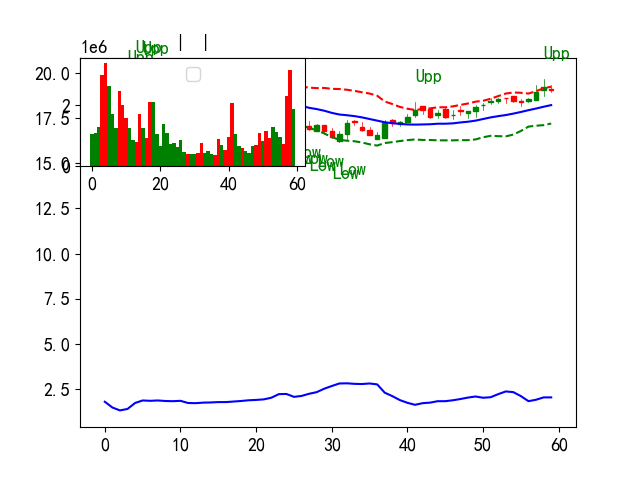

In [196]:
show_ohlc_upper(dfs.loc['300540'][-60:])

### mask250

In [198]:
mask250 = ((dfs_tail9[('high')] > dfs_tail9.upper) &
           (dfs_tail9[('close')] > dfs_tail9[('ma5')])
           & (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
           & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift( 1)*0.99))
           & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
           & (dfs_tail9['close'] > dfs_tail9[('hmax')]) &
            (dfs_tail9[('close')] > dfs_tail9[('ma250')]) | ((dfs_tail9[('high')] > dfs_tail9.upper) &
                                                             (dfs_tail9[('close')] > dfs_tail9[('ma5')])) &
           (dfs_tail9[('ma5')] > dfs_tail9[('ma20')])
           & ((dfs_tail9[('vol1d')] > 0) | (dfs_tail9.close > dfs_tail9.close.shift(1)*0.99))
           & ((dfs_tail9[('vol2d')] > 0) | (dfs_tail9.close.shift(1) > dfs_tail9.close.shift(2)*0.99))
           & (dfs_tail9['low'] > dfs_tail9[('low')].shift(1))
           & (dfs_tail9[('close')] > dfs_tail9[('ma250')])
           )


# & (dfs_tail9[('close')] < dfs_tail9[('ma20'  )]*1.1))
idx = pd.IndexSlice
df_mask250 = dfs_tail9.loc[idx[mask250, :]]
df_mask250 = get_multi_code_count(df_mask250)


code_t = '300613'
print((df_mask250.couts[:3], df_mask250.shape))
# df_mask250.loc[code_t]
groupd250 = df_mask250.groupby(level=[0])
df_mask250 = groupd250.tail(1).reset_index().set_index('code')
# df_mask250 = get_sina_data_cname(df_mask250, dm,realtime=True)


# df_mask250.loc[code_t].close
df_mask250 = get_sina_data_cname(df_mask250, realtime=True)
# df_mask250.loc[code_t].close

df_mask250 = clean_688(df_mask250)
# df_masklastd.loc['002722']

df_mask250 = df_mask250.sort_values(
    by=['idx','xratio',  'hat', 'perc1d'],
    ascending=[0, 0, 0, 0])
    # by=['xratio', 'idx', 'hat', 'perc1d'],

# by=['perc', 'perc5d', 'perc1d'],
# ascending=[0, 0, 0])
cross_hmax_250 = [co for co in df_mask250.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))

show_tdx_data(df_mask250[df_mask250.perc > 0])
# show_tdx_data(df_mask250.loc[code_t])

count dd.couts
(code    date      
688787  2023-01-30    8
300418  2023-01-30    8
002903  2023-01-30    8
Name: couts, dtype: int64, (5047, 31))
compute percent
cross_hamx:561
Count:519 40


,name,couts,date,perc,xratio,idx,hat,close,volsum5d,hmax,...,ma250,nclose,llow,vol1d,vol2d,vol3d,vol4d,vol5d,perc3d,perc5d
code,,,,,,,,,,,,,,,,,,,,,
600702,舍得酒业,2,2023-02-02,3.01,1.75,25.14,36.76,197.36,262.2,194.50,...,163.25,196.203123,181.51,31.63,-13.12,-57.72,274.63,26.74,3.75,11.63
300114,中航电测,6,2023-02-09,19.99,2.32,20.96,24.72,37.93,82.9,31.61,...,11.95,37.930000,31.61,22.04,24.89,62.54,-5.21,-21.40,72.83,148.90
301312,智立方,2,2023-02-03,0.97,2.27,15.81,37.05,120.00,172.5,126.05,...,72.50,121.156413,116.00,5.65,128.73,-13.42,16.46,35.13,16.61,22.25
301191,菲菱科思,3,2023-02-09,0.83,1.11,14.85,16.62,94.63,352.7,98.81,...,60.10,95.724937,82.10,233.76,43.70,-8.53,99.22,-15.47,14.75,15.86
605089,味知香,2,2023-02-06,4.78,2.02,13.50,17.38,82.25,130.2,81.28,...,60.48,79.852523,75.80,-39.46,40.46,140.65,37.32,-48.75,20.94,24.30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600085,同仁堂,1,2023-01-30,0.04,-0.28,-1.30,5.73,45.70,8.5,49.00,...,45.89,45.797008,46.80,49.93,20.86,-5.00,-3.54,-53.78,5.31,2.85
603882,金域医学,1,2023-01-30,2.78,-0.34,-1.33,22.08,87.70,71.9,92.50,...,74.19,87.712250,86.04,122.80,-35.36,8.69,-13.50,-10.71,8.91,7.65
301373,C凌玮,1,2023-02-08,9.87,-2.83,-2.83,18.23,44.52,540.4,45.99,...,29.95,43.432088,42.98,500.59,-18.89,-46.52,159.35,-54.11,80.32,85.65


### Tail1

In [165]:
# df_masklastd = df_mask250[(df_mask250.date >= '2023-02-06') & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0) &
df_masklastd = df_mask250[(df_mask250.date >= lastday) & (df_mask250.perc1d < 21) & (df_mask250.perc2d > 0)
                          & ((df_mask250.volsum5d > 50) )
                          ]
                          # & ((df_mask250.perc3d > 0) | ((df_mask250.close.shift(2) > df_mask250.ma5.shift(2))) )

# (df_mask250.couts == 1) & (df_mask250.perc1d < 21)]


print("src:%s  lastd:%s " % (df_mask250.shape, df_masklastd.shape))


df_masklastd = df_masklastd.sort_values(
    by=['perc5d', 'perc1d'],
    ascending=[0, 0])

# print(
#     (df_masklastd.loc
#      [:, ['name', 'couts', 'date', 'perc1d', 'perc3d', 'perc5d']][:10],
#      df_masklastd.shape,))

show_tdx_data(df_masklastd[:10]).T
show_tdx_data(df_masklastd[-10:]).T


code_t = '300675'
code_t = '605268'
code_t = '002828'
code_t = '300418'

df_masklastd.loc[code_t, ['name', 'couts',
                          'date', 'perc1d', 'perc3d', 'perc5d']]

# df_masklastd.loc[code_t].date


# df_mask250 = groupd250.head(1)

# df_masklastd.loc[code_t].date
# show_tdx_data(df_masklastd.loc[code_t])


show_tdx_data(df_masklastd.loc[code_t])

src:(1871, 40)  lastd:(197, 40) 
Count:10 40


code,300114,301205,603281,600817,300317,002229,601360,300848,300875,002951
name,中航电测,联特科技,江瀚新材,宇通重工,珈伟新能,鸿博股份,三六零,美瑞新材,捷强装备,金时科技
couts,6,5,3,4,2,8,2,5,2,6
date,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00
perc,19.99,-4.03,-5.05,-2.29,-10.6,9.96,-3.61,-3.78,-5.65,10.01
xratio,2.32,2.97,1.69,0.47,0.21,0.39,0.25,1.28,0.73,0.26
idx,20.96,31.45,3.37,4.63,2.46,4.12,2.66,10.74,7.64,2.99
hat,24.72,34.65,32.72,5.33,2.64,4.67,3.09,16.25,9.28,3.02
close,37.93,69.86,61.09,13.63,6.83,11.92,9.35,37.64,36.22,13.3
volsum5d,82.9,489.2,763.8,1079.7,607.2,432.5,1273.1,280.4,1277.7,317.6
hmax,31.61,72.79,67.66,13.95,7.97,10.84,9.7,40.1,40.08,12.09


Count:10 40


code,301216,600243,601858,002915,600380,300105,600421,600573,301260,603348
name,万凯新材,青海华鼎,中国科传,中欣氟材,健康元,龙源技术,华嵘控股,惠泉啤酒,C格力博,文灿股份
couts,3,1,2,2,2,3,4,2,1,1
date,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00,2023-02-09 00:00:00
perc,0.36,1.12,10.04,-0.31,-2.11,2.78,0.76,1.13,-3.85,-1.1
xratio,0.06,0.03,0.02,0.13,0.01,0.02,0.03,0.13,1.41,0.66
idx,0.9,0.37,0.66,1.64,0.32,0.42,0.6,1.27,1.41,9.5
hat,1.71,0.56,1.87,2.93,0.89,0.57,1.19,1.77,5.86,9.9
close,30.86,4.5,13.37,22.52,12.07,8.49,11.99,11.62,38.18,66.45
volsum5d,116.7,55.2,74.6,96.7,291.8,111.6,113.9,50.6,5426.0,82.6
hmax,30.9,4.55,13.09,22.95,12.38,8.52,12.2,11.64,41.92,71.18


KeyError: '300418'

### Cross_hmax_250

In [82]:
# dfs.loc[code_t].ma5
cross_hmax_250 = [co for co in df_masklastd.index.get_level_values(
    'code') if co in df_mask_hmax.index.get_level_values('code')]
# df_mask250.loc[code_t]
print("cross_hamx:%s" % (len(cross_hmax_250)))
show_tdx_data(df_masklastd.loc[cross_hmax_250])

NameError: name 'df_mask_hmax' is not defined

## 写入061

In [83]:
# write_code_to_blk(df_masklastd.index.tolist(),'061')
# write_code_to_blk(cross_hmax_250,'061')

In [84]:
# print(df_masklastd.loc['301255'].date)

# 默认年线筛选

In [85]:
top_temp.shape
top_temp.index

(198, 33)

Index(['301239', '301333', '301230', '600583', '300585', '605020', '001223',
       '603728', '002254', '000819',
       ...
       '300845', '601965', '603289', '300331', '300002', '002987', '003032',
       '002882', '603161', '300491'],
      dtype='object', name='code', length=198)

## plt.close('all')

In [135]:
plt.close('all')

# 写入060

In [86]:
if app:
    print("Write blk:%s" % (block_path))
    hdf5_wri = cct.cct_raw_input("rewrite code [Y] or append [N]:")
    if len(hdf5_wri) == 0:
        pass
    elif hdf5_wri == 'y' or hdf5_wri == 'Y':
        append_status = False
    else:
        append_status = True
else:
    append_status = False

if hdf5_wri == 'y' and len(codew) > 10:
    cct.write_to_blocknew(
        block_path, codew, append_status, doubleFile=False, keep_last=0)
    print("write:%s block_path:%s" % (len(codew), block_path))
else:
    print("write error:%s block_path:%s" % (len(codew), block_path))

Write blk:D:\MacTools\WinTools\new_tdx\T0002\blocknew\060.blk


rewrite code [Y] or append [N]: 


write error:198 block_path:D:\MacTools\WinTools\new_tdx\T0002\blocknew\060.blk
